In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BASE_DIR = "/content/drive/MyDrive/input"
WORKING_DIR = "/content/drive/MyDrive/working/"

In [3]:
import kagglehub


path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:13<00:00, 84.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [4]:
pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.7 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
from tqdm.notebook import tqdm
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout,add
import dill

In [6]:
model = VGG16()
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
features = {}
directory = "/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images"
for image_name in tqdm(os.listdir(directory)):
    image_path = os.path.join(directory, image_name)
    image = load_img(image_path,target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image,verbose=0)
    image_id = image_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
dill.dump(features,WORKING_DIR+"features.pkl")

In [12]:
directory = "/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/"
with open(os.path.join(directory,'captions.txt')) as f:
    next(f)
    captions_doc = f.read()

In [13]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(",")
    if len(tokens)<2 :
      continue
    image_id,caption = tokens[0],tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
      mapping[image_id] = [caption]
    else :
      mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
def clean(mapping) :
  for key,captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+',' ')
      caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption
clean(mapping)

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
dill.dump(features,WORKING_DIR+"all_captions.pkl")

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [17]:
vocab_size

8485

In [18]:
max_len = max(len(caption.split()) for caption in all_captions)
max_len

35

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
def data_generator(data_keys,mapping,features,tokenizer,max_len,vocab_size,batch_size):
  X1,X2,y = list(),list(),list()
  n = 0
  while 1 :
    for key in data_keys :
      n += 1
      for caption in mapping[key] :
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1,len(seq)):
          in_seq,out_seq = seq[:i],seq[i]
          in_seq = pad_sequences([in_seq],maxlen=max_len,padding='post')[0]
          out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n==batch_size :
        n = 0
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield {"image": X1, "text": X2}, y
        X1,X2,y = list(),list(),list()

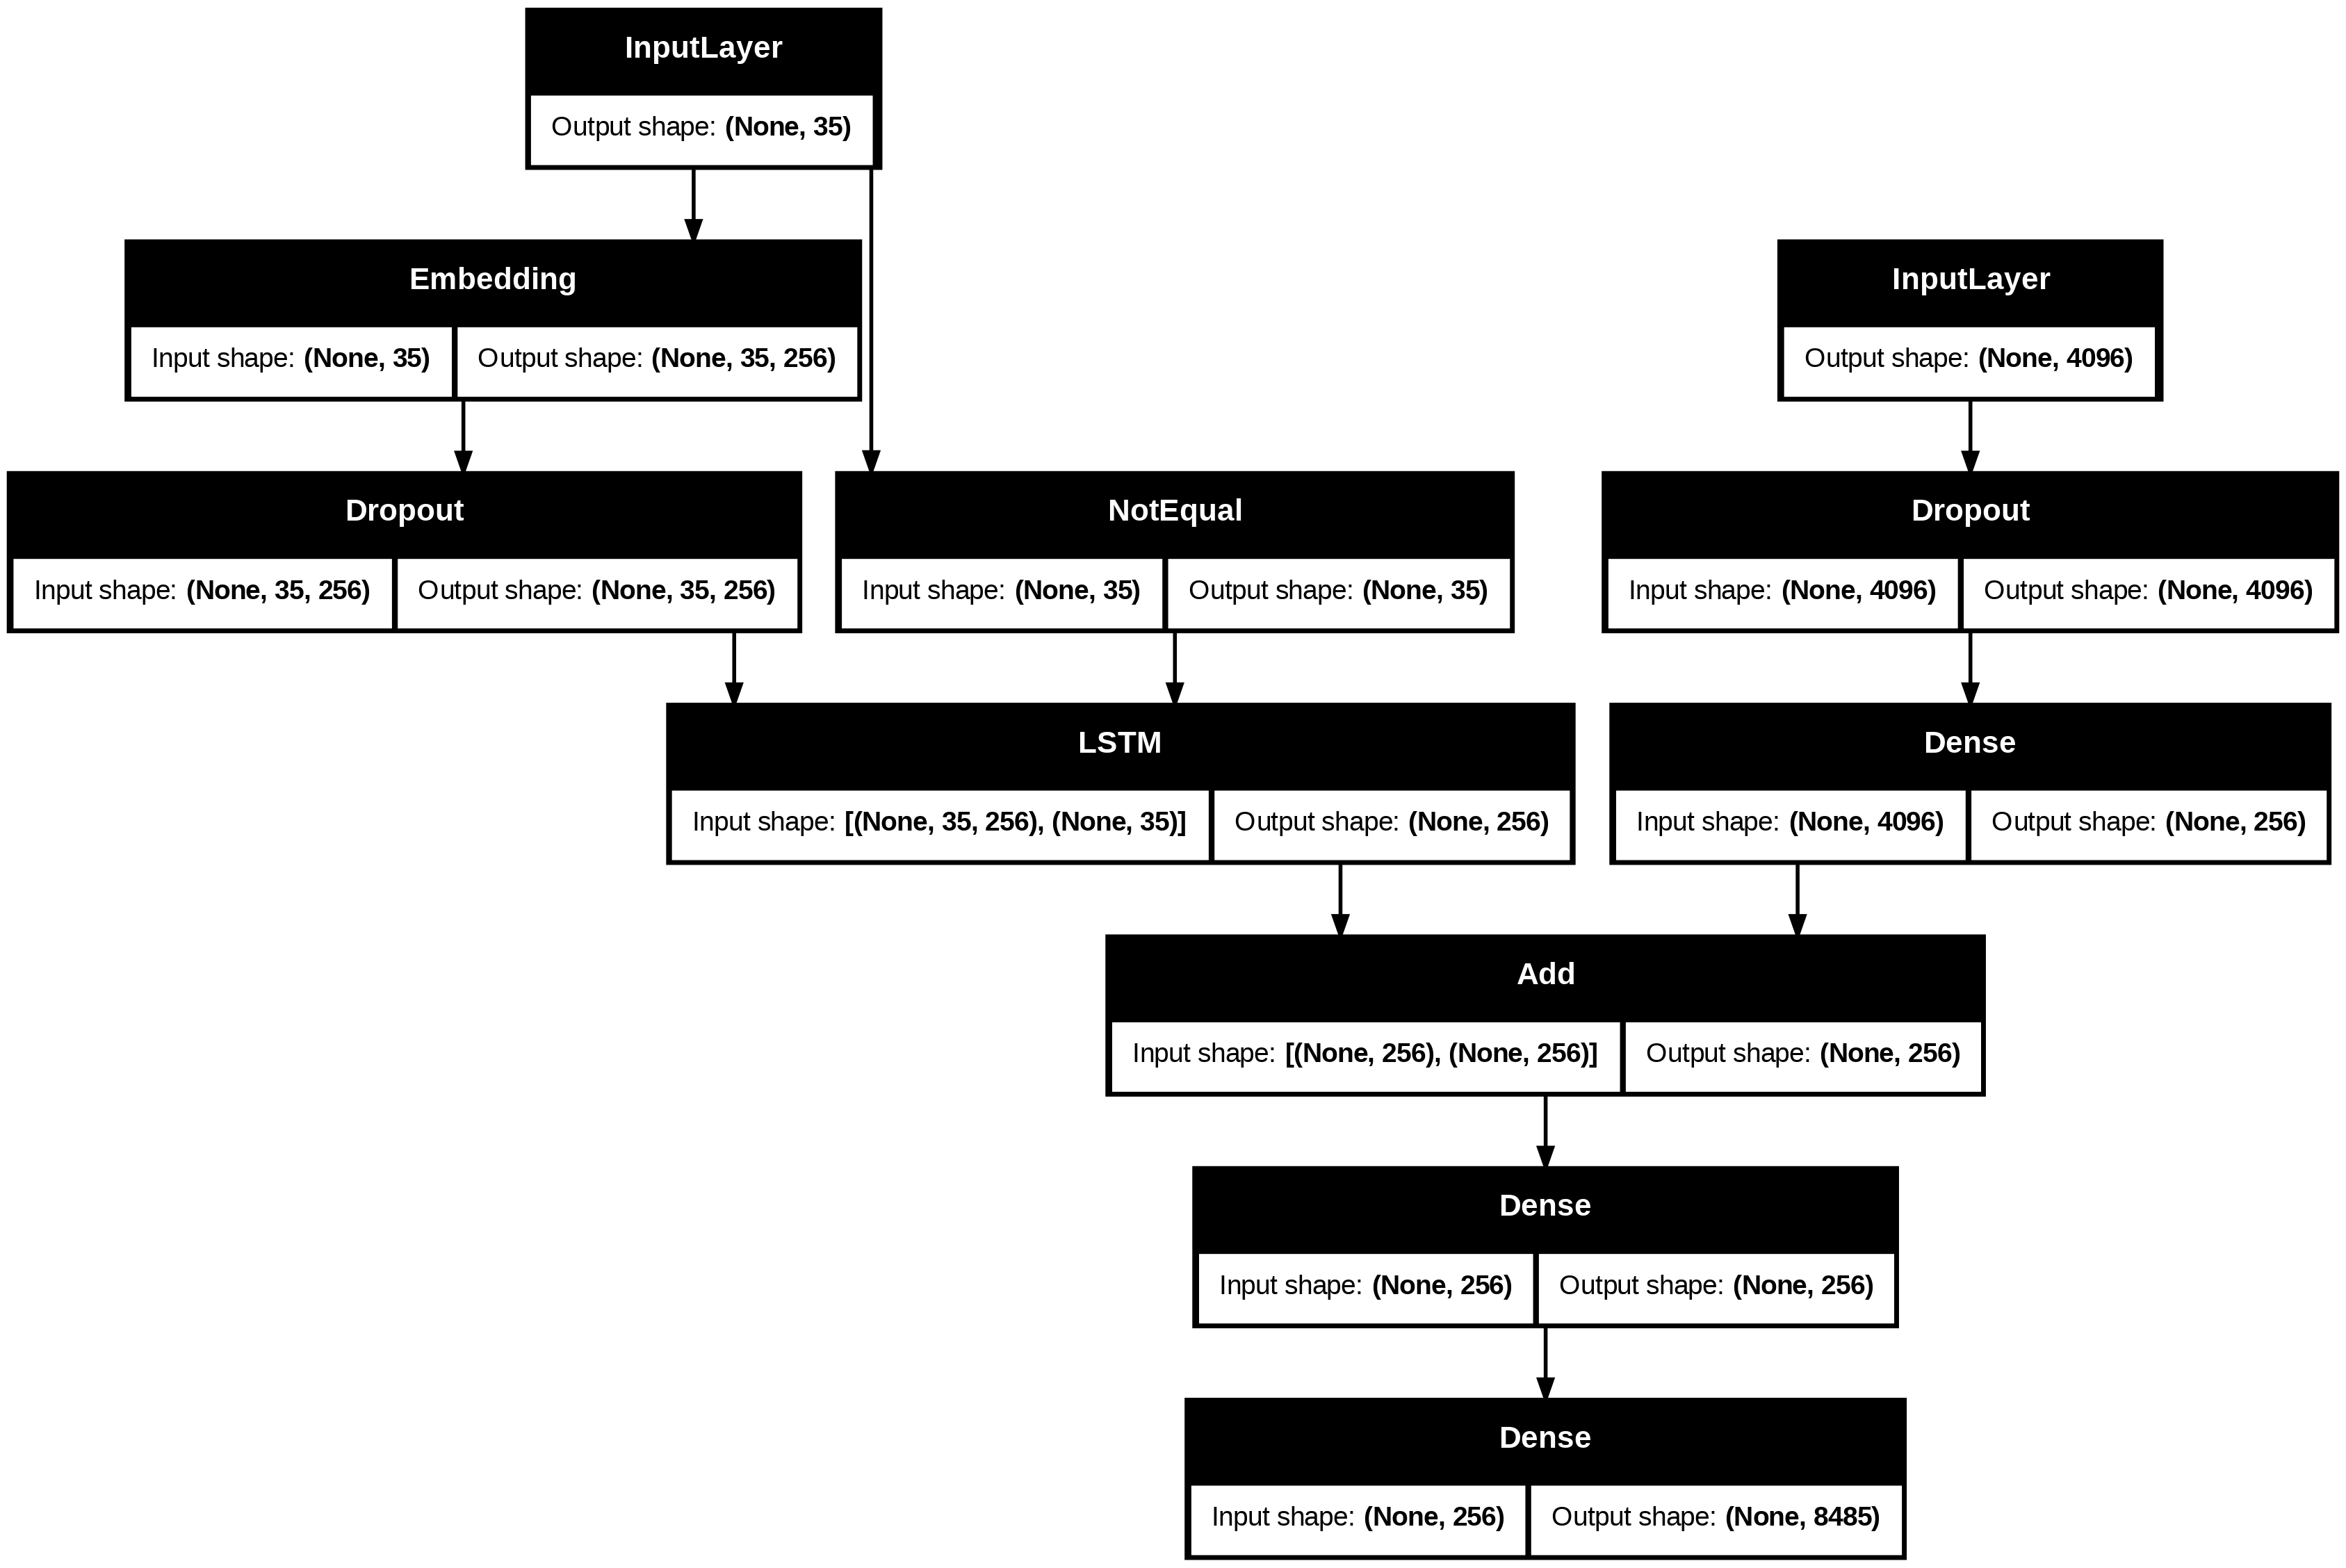

In [21]:
# In the model definition where the LSTM layer is created
inputs1 = Input(shape=(4096,),name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu') (fe1)
# sequence feature layers
inputs2 = Input(shape=(max_len,),name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)

se3 = LSTM(256,use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu') (decoder1)
outputs = Dense(vocab_size, activation='softmax') (decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [22]:
epochs = 6
batch_size = 64
steps = len(train)//batch_size
for i in range(epochs) :
  generator = data_generator(train,mapping,features,tokenizer,max_len,vocab_size,batch_size)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 457s 4s/step - loss: 6.1582
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 573ms/step - loss: 4.4819
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 573ms/step - loss: 3.8062
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 586ms/step - loss: 3.4898
113/113 ━━━━━━━━━━━━━━━━━━━━ 69s 613ms/step - loss: 3.2769
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 638ms/step - loss: 3.1211


In [23]:
model.save(WORKING_DIR+"best_model.h5")

In [24]:
def idx_to_word(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == integer :
      return word
  return None

In [25]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq '
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_len)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.500000
BLEU-2: 0.277350
BLEU-1: 0.565217
BLEU-2: 0.366845
BLEU-1: 0.254237
BLEU-2: 0.150664
BLEU-1: 0.263889
BLEU-2: 0.139297
BLEU-1: 0.320988
BLEU-2: 0.183816
BLEU-1: 0.315217
BLEU-2: 0.171238
BLEU-1: 0.323232
BLEU-2: 0.167652
BLEU-1: 0.348214
BLEU-2: 0.200446
BLEU-1: 0.349593
BLEU-2: 0.199665
BLEU-1: 0.388060
BLEU-2: 0.216663
BLEU-1: 0.406897
BLEU-2: 0.220419
BLEU-1: 0.429487
BLEU-2: 0.231702
BLEU-1: 0.449704
BLEU-2: 0.227791
BLEU-1: 0.447514
BLEU-2: 0.225643
BLEU-1: 0.444444
BLEU-2: 0.226021
BLEU-1: 0.443350
BLEU-2: 0.217755
BLEU-1: 0.454976
BLEU-2: 0.221923
BLEU-1: 0.468182
BLEU-2: 0.245481
BLEU-1: 0.464135
BLEU-2: 0.248481
BLEU-1: 0.469880
BLEU-2: 0.260215
BLEU-1: 0.471698
BLEU-2: 0.256376
BLEU-1: 0.478102
BLEU-2: 0.264948
BLEU-1: 0.491166
BLEU-2: 0.274889
BLEU-1: 0.500000
BLEU-2: 0.286513
BLEU-1: 0.511706
BLEU-2: 0.302505
BLEU-1: 0.524430
BLEU-2: 0.311525
BLEU-1: 0.520635
BLEU-2: 0.306600
BLEU-1: 0.524540
BLEU-2: 0.313961
BLEU-1: 0.523529
BLEU-2: 0.309762
BLEU-1: 0.5224

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_len)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy is riding dolly passed two 1950s cars endseq
startseq boy pushes his scooter endseq
startseq man pushes cart on street near some old cars endseq
startseq person in brown and two older cars in front of white building endseq
startseq young dark-skinned boy pushes cart on street with old cars endseq
--------------------Predicted--------------------
startseq  man in red shirt and black shirt is walking on sidewalk endseq


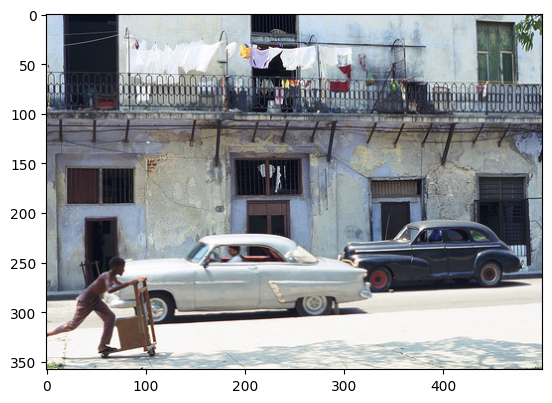

In [32]:
generate_caption("839295615_bb9baf2f95.jpg")

In [29]:
test

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b',
 '439492931_a96d590e40',
 '439569646_c917f1bc78',
 '439916996_1ddb9dc8e7',
 '440184957_267f3f3a2b',
 '440190907_bf8b7ba8ef',
 '440737340_5af34ca9cf',
 '441212506_fcc321ac28',
 '44129946_9eeb385d77',
 '441398149_297146e38d',
 '441817653_fbdf83060b',
 '441921713_1cafc7d7d2',
 '442220883_ff3d6e507f',
 '442594271_2c3dd38483',
 '442918418_0f29c97fa9',
 '443430496_3fea95a07d',
 '443885436_6e927e6c58',
 '444047125_66b249287c',
 '444057017_f1e0fcaef7',
 '444481722_690d0cadcf',
 '444803340_fdcaab86f9',
 '444845904_a4531c811a',
 '444872454_9f51e07f88',
 '444881000_bba92e585c',
 '445148321_9f2f3ac711',
 '445655284_c29e6d7323',
 '445861800_75fc6a8c16',
 '446138054_d40c66d5f0',
 '446286714_dcec7f339e',
 '446291803_2fd4641b99',
 '446514680_ff5ca15ece',
 